In [2]:
import cartopy.crs as ccrs
import xarray as xr

### Opening the dataset with `open_datatree()`

In [ ]:
precipitation = xr.open_datatree('precipitation.nc4')


<xarray.DataArray 'precipitation' (time: 10, lon: 320, lat: 150)> Size: 2MB
[480000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 80B 2021-08-29T07:30:00 ... 2021-08-29T16:...
  * lon      (lon) float32 1kB -109.9 -109.8 -109.8 ... -78.25 -78.15 -78.05
  * lat      (lat) float32 600B 20.05 20.15 20.25 20.35 ... 34.75 34.85 34.95
Attributes:
    LongName:          \nComplete merged microwave-infrared (gauge-adjusted)\...
    Units:             mm/hr
    units:             mm/hr
    CodeMissingValue:  -9999.9
    DimensionNames:    time,lon,lat

In [37]:
import netCDF4 as nc4

precipitation = nc4.Dataset('precipitation.nc4')
observed = precipitation['/observed/precipitation'][0,:,:]
reanalysis = precipitation['/reanalysis/precipitation'][0,:,:]
subset = nc4.Dataset('precipitation_subset.nc4', 'w', format='NETCDF4')


In [47]:
import xarray as xr

ds_groups = xr.open_groups('precipitation.nc4')
ds_groups

{'/': <xarray.Dataset> Size: 80B
 Dimensions:  (time: 10)
 Coordinates:
   * time     (time) datetime64[ns] 80B 2021-08-29T07:30:00 ... 2021-08-29T16:...
 Data variables:
     *empty*,
 '/observed': <xarray.Dataset> Size: 2MB
 Dimensions:        (time: 10, lon: 320, lat: 150)
 Coordinates:
   * lon            (lon) float32 1kB -109.9 -109.8 -109.8 ... -78.15 -78.05
   * lat            (lat) float32 600B 20.05 20.15 20.25 ... 34.75 34.85 34.95
 Dimensions without coordinates: time
 Data variables:
     precipitation  (time, lon, lat) float32 2MB ...,
 '/reanalysis': <xarray.Dataset> Size: 65kB
 Dimensions:        (time: 10, lat: 31, lon: 52)
 Coordinates:
   * lon            (lon) float64 416B -110.0 -109.4 -108.8 ... -78.75 -78.12
   * lat            (lat) float64 248B 20.0 20.5 21.0 21.5 ... 34.0 34.5 35.0
 Dimensions without coordinates: time
 Data variables:
     precipitation  (time, lat, lon) float32 64kB ...}

In [61]:
for group_name, dataset in ds_groups.items():
    print(f"Processing group: {group_name}")
    # Perform operations on each dataset
    print(dataset)

Processing group: /
<xarray.Dataset> Size: 80B
Dimensions:  (time: 10)
Coordinates:
  * time     (time) datetime64[ns] 80B 2021-08-29T07:30:00 ... 2021-08-29T16:...
Data variables:
    *empty*
Processing group: /observed
<xarray.Dataset> Size: 2MB
Dimensions:        (time: 10, lon: 320, lat: 150)
Coordinates:
  * lon            (lon) float32 1kB -109.9 -109.8 -109.8 ... -78.15 -78.05
  * lat            (lat) float32 600B 20.05 20.15 20.25 ... 34.75 34.85 34.95
Dimensions without coordinates: time
Data variables:
    precipitation  (time, lon, lat) float32 2MB ...
Processing group: /reanalysis
<xarray.Dataset> Size: 65kB
Dimensions:        (time: 10, lat: 31, lon: 52)
Coordinates:
  * lon            (lon) float64 416B -110.0 -109.4 -108.8 ... -78.75 -78.12
  * lat            (lat) float64 248B 20.0 20.5 21.0 21.5 ... 34.0 34.5 35.0
Dimensions without coordinates: time
Data variables:
    precipitation  (time, lat, lon) float32 64kB ...


In [2]:
import netCDF4 as nc4
import numpy as np

# Open original file
src = nc4.Dataset('precipitation.nc4', 'r')

# Create new file
dst = nc4.Dataset('precipitation_subset.nc4', 'w', format='NETCDF4')

def copy_dims(src_group, dst_group, time_subset=False):
    for dim_name, dim in src_group.dimensions.items():
        if time_subset and dim_name == 'time':
            dst_group.createDimension(dim_name, 1)  # only keep first time step
        else:
            dst_group.createDimension(dim_name, len(dim) if not dim.isunlimited() else None)

def copy_vars(src_group, dst_group):
    for var_name, var in src_group.variables.items():
        dims = var.dimensions
        new_var = dst_group.createVariable(var_name, var.datatype, dims)

        # Copy attributes
        new_var.setncatts({k: var.getncattr(k) for k in var.ncattrs()})

        # Subset first time step if "time" is first dimension
        if 'time' in dims:
            time_axis = dims.index('time')
            # Build slicing tuple like: [0, :, :] or [0, :, :, ...]
            slicer = [slice(None)] * len(dims)
            slicer[time_axis] = 0
            new_var[:] = var[tuple(slicer)][np.newaxis if time_axis == 0 else ...]
        else:
            new_var[:] = var[:]

def recursive_copy(src_group, dst_group):
    dst_group.setncatts({attr: src_group.getncattr(attr) for attr in src_group.ncattrs()})
    copy_dims(src_group, dst_group, time_subset=True)
    copy_vars(src_group, dst_group)

    # Copy lat/lon from root group
    if src_group == src:
        for coord_name in ['lat', 'lon']:
            if coord_name in src_group.variables and coord_name not in dst_group.variables:
                coord_var = src_group.variables[coord_name]
                dst_coord = dst_group.createVariable(coord_name, coord_var.datatype, coord_var.dimensions)
                dst_coord.setncatts({k: coord_var.getncattr(k) for k in coord_var.ncattrs()})
                dst_coord[:] = coord_var[:]

    for name, subgrp in src_group.groups.items():
        dst_subgrp = dst_group.createGroup(name)
        recursive_copy(subgrp, dst_subgrp)

# Begin with root group
recursive_copy(src, dst)

# Close files
src.close()
dst.close()


### Creating a DataTree from a dictionary with `DataTree.from_dict()`
You can create a DataTree from a dictionary of `xr.Datasets` objects or `xr.DataTree` objects.
The key of the dictionary is the node/group of the new DataTree object.

In [ ]:
xr.DataTree.from_dict({'new_group': precipitation})

# For preprocessing/creating dataset

<xarray.DataTree>
Group: /
└── Group: /new_group
    │   Dimensions:  (time: 10)
    │   Coordinates:
    │     * time     (time) datetime64[ns] 80B 2021-08-29T07:30:00 ... 2021-08-29T16:...
    ├── Group: /new_group/observed
    │       Dimensions:        (time: 10, lon: 320, lat: 150)
    │       Coordinates:
    │         * lon            (lon) float32 1kB -109.9 -109.8 -109.8 ... -78.15 -78.05
    │         * lat            (lat) float32 600B 20.05 20.15 20.25 ... 34.75 34.85 34.95
    │       Data variables:
    │           precipitation  (time, lon, lat) float32 2MB ...
    └── Group: /new_group/reanalysis
            Dimensions:        (time: 10, lat: 31, lon: 52)
            Coordinates:
              * lon            (lon) float64 416B -110.0 -109.4 -108.8 ... -78.75 -78.12
              * lat            (lat) float64 248B 20.0 20.5 21.0 21.5 ... 34.0 34.5 35.0
            Data variables:
                precipitation  (time, lat, lon) float32 64kB ...

### Plot the data with `.plot()` as a `FacetGrid` object
We can use `xarray.plot.FacetGrid` objects to make plots with multiple axes. Each axes shows the same relationship conditioned on different levels of some dimension, in our case different time stamps. Note since this data is two-dimensional it calls `xarray.plot.pcolormesh()` by default with just the `.plot()` method.

### Add a custom precipitation color map from [metpy](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.ctables.html)

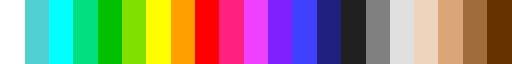

In [18]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap

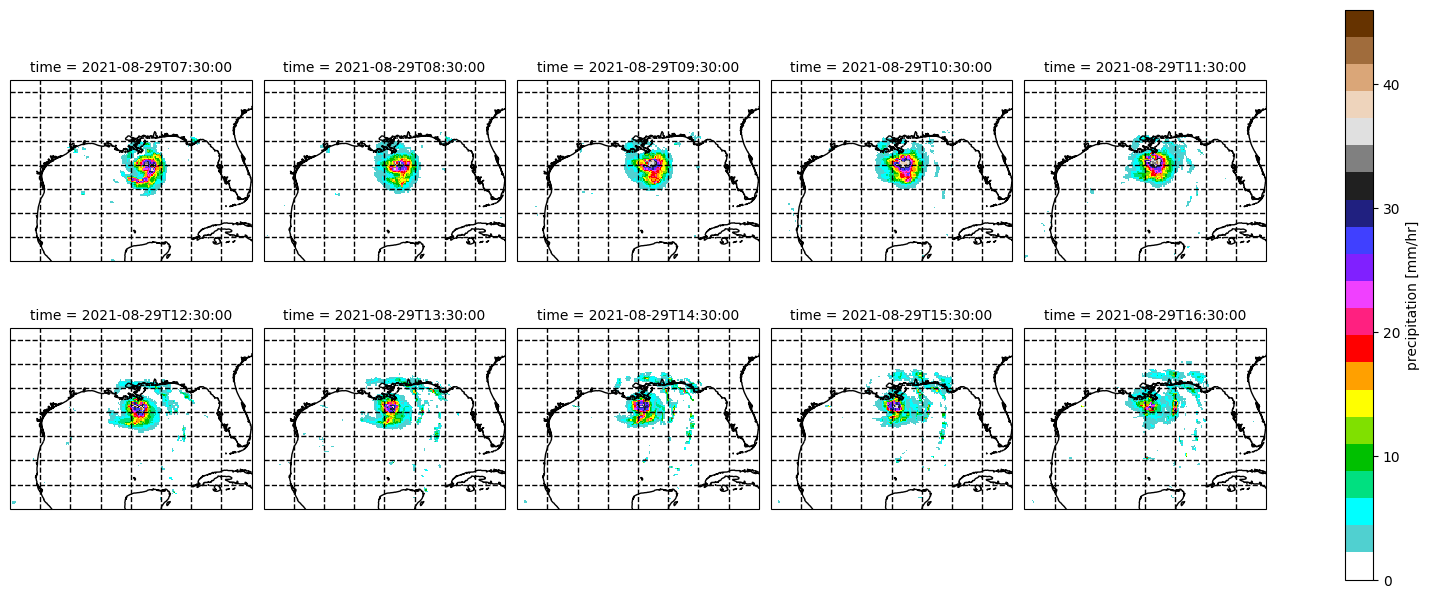

In [19]:
# Plot the precipitation data for the observed group
precip_plot = precipitation.observed.precipitation.plot(
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.PlateCarree()},
    x="lon",
    y="lat",
    col='time',  # The dimension ("time") we are faceting our plot on
    col_wrap=5,  # Number of subplots
    cmap=cmap,
    vmin=precipitation.observed.precipitation.min(),
    vmax=precipitation.observed.precipitation.max(),
)


for ax in precip_plot.axs.flat:
    ax.set_extent([-100, -80, 20, 35])
    ax.coastlines()
    gl = ax.gridlines(linewidth=1, color='black', linestyle='--')

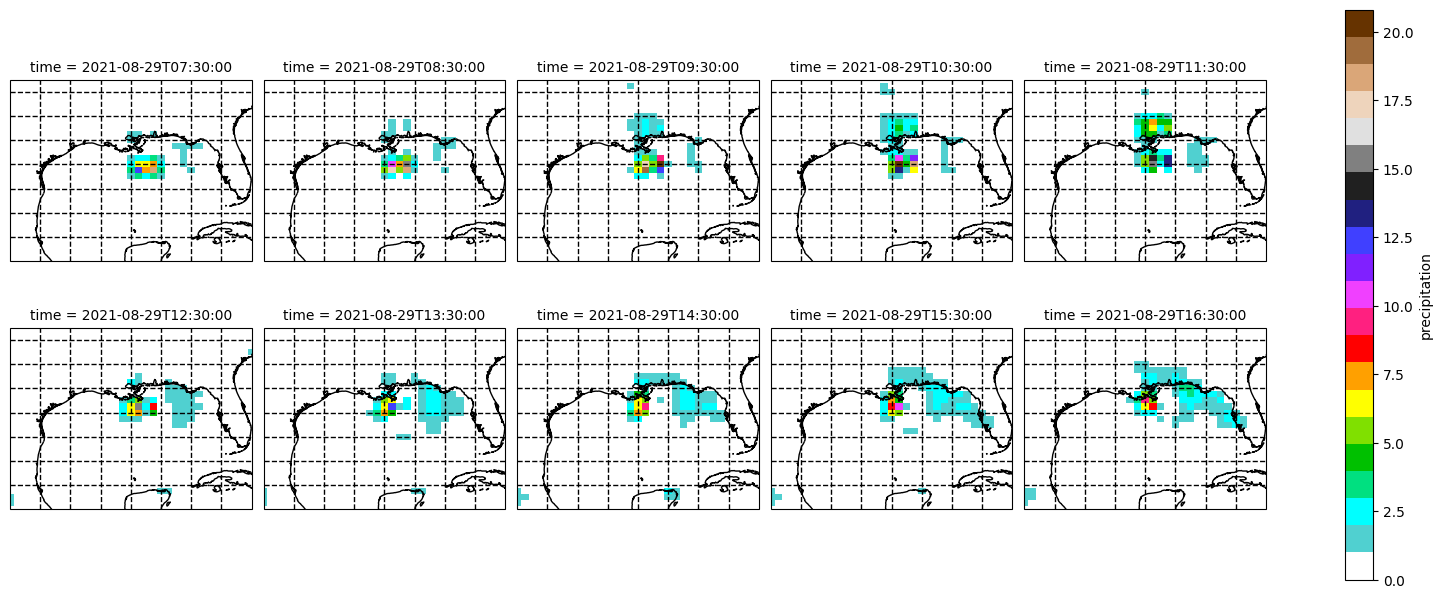

In [20]:
# Plot the precipitation data for the reanalysis group
precip_plot = precipitation.reanalysis.precipitation.plot(
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.PlateCarree()},
    x="lon",
    y="lat",
    col='time',  # The dimension ("time") we are faceting our plot on
    col_wrap=5,  # Number of subplots
    cmap=cmap,
    vmin=precipitation.reanalysis.precipitation.min(),
    vmax=precipitation.reanalysis.precipitation.max(),
)


for ax in precip_plot.axs.flat:
    ax.set_extent([-100, -80, 20, 35])
    ax.coastlines()
    gl = ax.gridlines(linewidth=1, color='black', linestyle='--')